Section 1

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_images(folder_path):
    images = []
    for file in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, file))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return images

def load_labels(folder_path):
    labels = []
    for file in os.listdir(folder_path):
        with open(os.path.join(folder_path, file), 'r') as f:
            data = f.readline().strip().split(' ')
            values = [float(value) for value in data[1:]]
            labels.append(values)
    return labels

def show_data(image, labels):
    image = image
    label = labels
    image_bbox = image.copy()
    x, y, w, h = labels
    x1, y1 = int((x - w / 2) * image.shape[1]), int((y - h / 2) * image.shape[0])
    x2, y2 = int((x + w / 2) * image.shape[1]), int((y + h / 2) * image.shape[0])
    
    plt.imshow(image)
    plt.title('test')
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2))
    plt.show()

In [3]:
# def load_test(file_path):
#     with open(file_path, 'r') as f:
#         data = f.readline().strip().split(' ')
#     return data

In [4]:
# data = np.array(load_test('test_file.txt')).astype('float32')

In [3]:
data_dir = 'dataset/'

In [4]:
train_images = np.array(load_images(data_dir + 'train/images'))#.astype('float32')
train_labels = np.array(load_labels(data_dir + 'train/labels'))#.astype('float32')
valid_images = np.array(load_images(data_dir + 'valid/images'))#.astype('float32')
valid_labels = np.array(load_labels(data_dir + 'valid/labels'))#.astype('float32')

In [6]:
test_images = load_images(data_dir + 'test/images')
test_labels = load_labels(data_dir + 'test/labels')

In [7]:
np_test_images = np.array(test_images)
np_test_labels = np.array(test_labels)

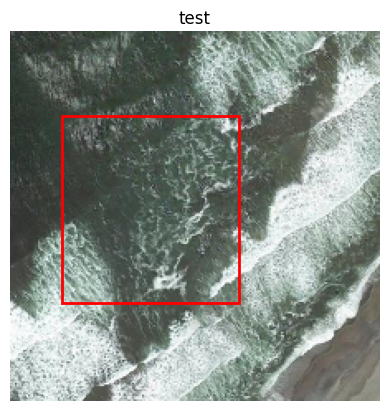

In [9]:
show_data(train_images[0], train_labels[0])

In [10]:
ex_idx = 0
print("train images:", train_images.shape)
# print("train image ex:\n", train_images[ex_idx])
print("train labels:", train_labels.shape)
# print("train label ex:\n", train_labels[ex_idx])
print("valid images:", valid_images.shape)
# print("valid image ex:\n", valid_images[ex_idx])
print("valid labels:", valid_labels.shape)
# print("valid label ex:\n", valid_labels[ex_idx])

train images: (984, 224, 224, 3)
train labels: (984, 4)
valid images: (280, 224, 224, 3)
valid labels: (280, 4)


Model

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV2

2023-07-05 12:49:26.271092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 12:49:28.248292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False #base model as feature ex

2023-07-05 12:49:33.362302: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-07-05 12:49:33.362389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: luthfi
2023-07-05 12:49:33.362415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: luthfi
2023-07-05 12:49:33.362611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-07-05 12:49:33.362686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-07-05 12:49:33.362707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [13]:
x = base_model.output
# x = Conv2D(256, (3, 3), activation="relu")(base_model.output)
# x = Flatten()(x)
x = GlobalAveragePooling2D()(x) #convert to 1280 vector of pred values
output = Dense(4)(x) #bbox only
model = Model(inputs=base_model.input, outputs=output)

In [14]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [ ]:
model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=10)

Epoch 1/10
31/31 [==============================] - 17s 456ms/step - loss: 0.7047 - accuracy: 0.3354 - val_loss: 0.6927 - val_accuracy: 0.3786
Epoch 2/10
31/31 [==============================] - 14s 442ms/step - loss: 0.6858 - accuracy: 0.3943 - val_loss: 0.6873 - val_accuracy: 0.4179
Epoch 3/10
31/31 [==============================] - 13s 435ms/step - loss: 0.6800 - accuracy: 0.4126 - val_loss: 0.6770 - val_accuracy: 0.4250
Epoch 4/10
31/31 [==============================] - 13s 424ms/step - loss: 0.6764 - accuracy: 0.4624 - val_loss: 0.6700 - val_accuracy: 0.4679
Epoch 5/10
31/31 [==============================] - 13s 423ms/step - loss: 0.6753 - accuracy: 0.4258 - val_loss: 0.6695 - val_accuracy: 0.4286
Epoch 6/10
22/31 [====================>.........] - ETA: 3s - loss: 0.6738 - accuracy: 0.4517

In [ ]:
loss = model.evaluate(test_images, test_labels)